### <span style="color:rgb(87,104,172)">Optimization for Machine Learning</span>

### <span style="color:rgb(87,104,172)">Master 2 IASD 2025-2026</span>


# <span style="color:rgb(87,104,172)">Lab session - Gradient-based methods (version with solutions and bonus tests)</span>

This lab session aims at illustrating the behavior of gradient descent on convex and strongly convex problems. We will first look at a toy quadratic problem, then switch to regression problems based on synthetic data.


This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OML/LabOML-GradientMethods-solutions.zip). The original version (revised but without the solutions) can be accessed [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OML/LabOML-GradientMethods.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**. 

*Thanks to the students from previous years who spotted my mistakes and provided feedback!*

#### <span style="color:rgb(87,104,172)">Preliminary remarks</span>

- This notebook and the subsequent ones used in this course mix Python code and text/LaTeX blocks. They can be run offline on any computer where Python and Jupyter are installed, or online using Google Colab (requires a Google account).

- All code blocks from this notebook are meant to be run in the order that they are given. In particular, the first block below must be run first in order to import the necessary toolboxes.

- All the notebooks from this course rely on Python and the NumPy library. A basic yet very useful tutorial on NumPy is freely available
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root
from math import ceil # Ceil integer operator
from math import log # Logarithm function

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import svdvals # Singular value decomposition
from scipy.linalg import qr # QR decomposition from linear algebra
from scipy.optimize import fmin_l_bfgs_b # An efficient minimization routine in moderate dimensions

**Useful NumPy routines (check documentation for more info)**

* *transpose* matrix (i.e. two-dimensional NumPy array) transpose operator.
* *matmul* matrix-matrix product (the two matrices should have the same number of rows/columns).
* *dot* matrix-vector product (dimensions permitting), can also be used as inner product operator between two vectors with samle length.
* *np.ones((m,n))* m-by-n matrix with all components equal to 1. 
* *np.zeros((m,n))* m-by-n matrix with all components equal to 1. 
* *np.identity(n)* square identity matrix of size n.
* *np.diag(v)* diagonal matrix defined by an array representing its diagonal elements.
* *np.pi* $\pi$ constant.
* *np.inf* represents an infinite number in memory.
* *np.log* componentwise logarithm for NumPy arrays.
* *np.exp* componentwise exponential for NumPy arrays.
* *np.sum* sum of the components of a NumPy array (for matrices, works along one dimension
* *np.maximum(u,v)* returns a NumPy array as output. The components of this array are $max(u_i,v_i)$, with $u_i$ and $v_i$ being the components of $u$ and $v$.
* *np.concatenate* concatenates NumPy arrays (vectors, matrices) of appropriate dimensions.
* If t is a NumPy array, the function *t.shape* returns the dimension(s) of that array (useful when one wants to define an array with the same dimensions.)

# <span style="color:rgb(87,104,172)">Part 1 - Gradient descent on strongly convex quadratic functions</span>

## <span style="color:rgb(87,104,172)"> 1.1 - Toy quadratic problem</span>

To begin this notebook, we will study the following quadratic optimization problem:
$$
    \min_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}):=\tfrac{1}{2}\mathbf{w}^T \mathbf{C} \mathbf{w},
$$
where $\mathbf{C} \in \mathbb{R}^d$ is a symmetric, positive definite matrix with eigenvalues
$$
    0 < \lambda_1 \le \dots \le \lambda_d.
$$

### <span style="color:rgb(87,104,172)">Observations</span> 

- The function is polynomial (even quadratic) in every variable, therefore it is (in particular) continuously differentiable.
- For any $\mathbf{w} \in \mathbb{R}^d$, the gradient of $f$ at $\mathbf{w}$ is given 
by $\nabla f(\mathbf{w})=\mathbf{C} \mathbf{w}$.
- The function $f$ is $\lambda_1$-strongly convex.
- The function $f$ is $\lambda_d$-smooth, i.e. $f$ has an $\lambda_d$-Lipschitz continuous gradient.
- $\min_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w})=0$.
- $\mathrm{argmin}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) = \left\{ \mathbf{0}_{\mathbb{R}^d} \right\}$.

#### <span style="color:rgb(87,104,172)">Details (solution version)</span> 

- For any real-valued function $t \mapsto a t^2+b t+c$ with $a,b,c \in \mathbb{R}$, the derivative is $t \mapsto 2 a t + b$. Applying this technique to all variables yields the desired formula.

- Although we have not used this at this stage of the course, one can of course justify that the function $q$ is convex using its Hessian matrix, equal to $\mathbf{C}$ for every $\mathbf{w} \in \mathbb{R}^d$, is positive semidefinite. Another possibility to show convexity consists in establishing the convexity inequality.
$$
    \forall (\mathbf{w},\mathbf{v}), \qquad f(\mathbf{v}) 
    \ge f(\mathbf{w}) + \nabla f(\mathbf{w})^T (\mathbf{v}-\mathbf{w}).
$$
This inequality holds here, since 
$$
    f(\mathbf{v}) - f(\mathbf{w}) - \nabla f(\mathbf{w})^T (\mathbf{v}-\mathbf{w}) 
    = \frac{1}{2}\mathbf{v}^T\mathbf{C}\mathbf{v} - \frac{1}{2}\mathbf{w}^T\mathbf{C}\mathbf{w} 
    - \mathbf{w}^T \mathbf{C}(\mathbf{v}-\mathbf{w})
    = \frac{1}{2}(\mathbf{v}-\mathbf{w})^T \mathbf{C} (\mathbf{v}-\mathbf{w}) \ge \lambda_1 \|\mathbf{v}-\mathbf{w}\|^2.
$$
When $\lambda_1>0$, the above reasoning also establishes that the function is $\lambda_1$-strongly convex.

- For any $(\mathbf{w},\mathbf{v}) \in \mathbb{R}^d$, we have 
$$
    \|\nabla f(\mathbf{v})-\nabla f(\mathbf{w})\| = \|\mathbf{C}(\mathbf{v}-\mathbf{w})\| 
    \le \| \mathbf{C}\| \|\mathbf{v}-\mathbf{w}\| = \lambda_d \|\mathbf{v}-\mathbf{w}\|.
$$

- Since $f(\mathbf{w}) \ge 0$ for any $\mathbf{w}$ and $f(\mathbf{0})=0$, we know that the optimal value is $0$. 

- When $\lambda_1>0$, the zero vector is the only vector such that $f(\mathbf{0})=0$, hence the minimization problem has a unique solution.

We generate the matrix as follows:

1) We generate a diagonal matrix $\mathbf{D}$ with eigenvalues randomly distributed in [$\mu$,$L$], where $L$ and $\mu$ are fixed, positive parameters, so as to guarantee that $\mu = \lambda_1 \le \cdots \le \lambda_d = L$.

2) We generate a random orthogonal matrix $\mathbf{Q}$ and define 
$
    \mathbf{C}=\mathbf{Q}^T \mathbf{D} \mathbf{Q}.
$
It follows that $\mathbf{C} \succeq \mu \mathbf{I}$, i.e. this matrix is positive definite.

We then consider the toy problem
$$
    \text{minimize}_{\mathbf{w} \in \mathbb{R}^d}\ \tfrac{1}{2}\mathbf{w}^T \mathbf{C} \mathbf{w}.
$$

In [2]:
# Defining two quadratic problems through (random) matrices

# Problem size
d=100

# Lipschitz constant
L=1

# Strong convexity constant
mu=0.01

# Fix random seed for reproducibility
np.random.seed(1)

# Generate a random orthogonal matrix Q
M = np.random.multivariate_normal(np.zeros(d),np.identity(d),size=d)
Q,R = qr(M) # Q is orthogonal by definition of the QR factorization

# Generate random eigenvalues between mu and L (procedure used for a better spread of the eigenvalues)
D = np.random.uniform(mu,L,d)
D = 10.**D
D = (D-min(D))/(max(D)-min(D))
D = mu+(L-mu)*D

D0 = D.copy()
D0[ceil(d/2):] = 0


# Produce matrix C
C = Q.T @ np.diag(D) @ Q

## <span style="color:rgb(87,104,172)">1.2 - Gradient descent</span>

We now define a gradient descent algorithm dedicated to our problem of interest. For this implementation, the method will use a constant stepsize, to be given as an input. Rather than stopping when a given convergence criterion is met, we run the algorithm for a fixed number of iterations.

### <span style="color:rgb(87,104,172)">Question 1</span> 

**Fill out the missing parts in the code below. Make sure the variables you use are consistent with that of the overall code.**

In [3]:
def gd_quad(w0,C,stepsize,n_iter=100, verbose=False): 
    """
        A code for gradient descent on quadratic functions.
        
        Inputs:
            w0: Initial vector
            C: Square matrix representing the objective function
            stepsize: Value of the (constant) stepsize
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter+1)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    ##########################################
    # FILL OUT THE MISSING LINE
    ##########################################
    
    # Current value for the objective function
    obj = 0.5*w.dot(C.dot(w))
    
    objvals.append(obj);
    
    g = C.dot(w)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        ##################################
        # FILL OUT THE MISSING PIECES!
        ##################################
        
        
        # Select the stepsize and perform the update
        w[:] = w - stepsize * g
        
        # Compute the new gradient
        g = C.dot(w)
        
        # Compute the new objective value 
        obj = 0.5*w.dot(g)
        
        
        ##################################
        # END FILL-OUT SECTION
        ##################################
        objvals.append(obj)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals)

### <span style="color:rgb(87,104,172)">Question 2 - Tests on the strongly convex quadratic problem</span>

**In this question, we consider the matrix $\mathbf{C}$ generated above, and the associated quadratic problem.**

**a) Run gradient descent using a fixed initial point (e.g. the vector of all ones) for 100 iterations using 5 different values for the 
stepsize (suggested: a value > 1, 1, 3 values <1 including). Can you find a stepsize greater than $1$ for which the method seems to converge/diverge? Can you find a stepsize smaller than $1$ for which the method does not appear to converge? What about the value $1$?**

**b) Repeat the experiment of question a) using $1000$ iterations instead. Do you observe any change in the ranking of all variants?**

**c) The choice $\frac{2}{\mu+L}$ is known to be optimal stepsize for quadratics that are both $L$-smooth and $\mu$-strongly convex. Do you observe this in your experiments?**

In [6]:
# Answer to question 2.a)

w_0 = np.ones(d)
n_iter = 100
##################
# 
vals_stepsize = [2,1,0.5,0.02,0.0001]
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(w_0,C,vals_stepsize[i_val],n_iter, verbose=False)


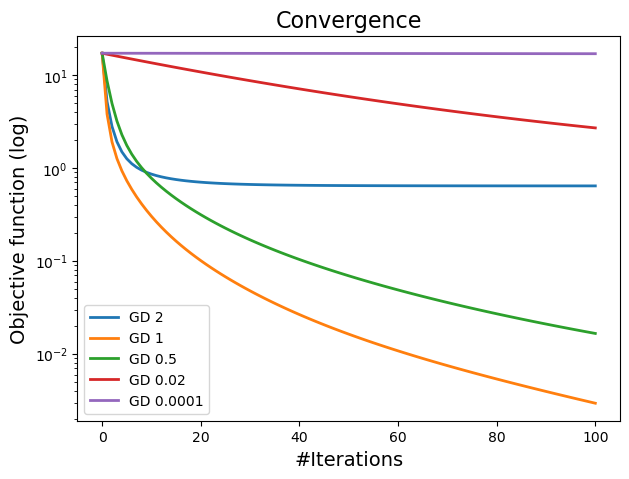

In [7]:
# Plotting the comparison
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    plt.semilogy(objs[:,i_val], label="GD "+str(vals_stepsize[i_val]), lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)

In [8]:
# Answer to question 2.b (changing the number of iterations)

w_0 = np.ones(d)
n_iter = 1000
##################
# 
vals_stepsize = [1.5,1,0.5,0.02,0.0001]
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(w_0,C,vals_stepsize[i_val],n_iter, verbose=False)

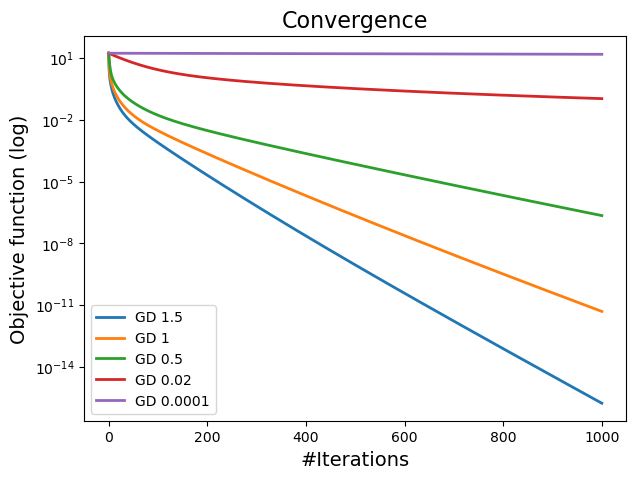

In [9]:
# Plotting the comparison
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    plt.semilogy(objs[:,i_val], label="GD "+str(vals_stepsize[i_val]), lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)

In [10]:
# Answer to question 2.c

w_0 = np.ones(d)
n_iter = 1000
##################
# 
vals_stepsize = [(L-mu)/(L+mu),2/(L+mu),1/L]#,0.5,1.5]
nvals = len(vals_stepsize)

objs = np.zeros((n_iter+1,nvals))

for i_val in range(nvals):
    _, objs[:,i_val] = gd_quad(w_0,C,vals_stepsize[i_val],n_iter, verbose=False)


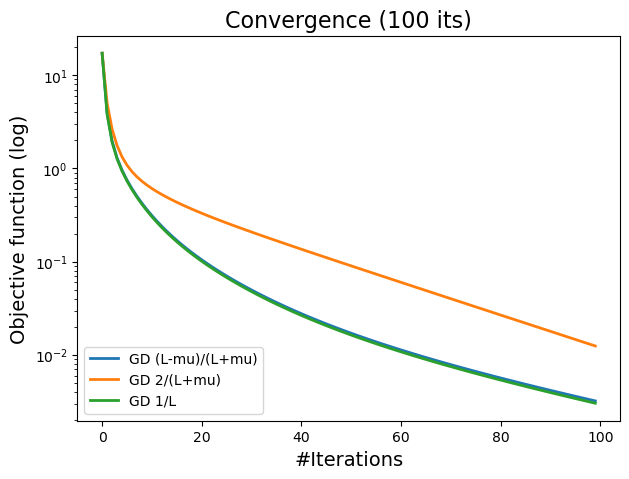

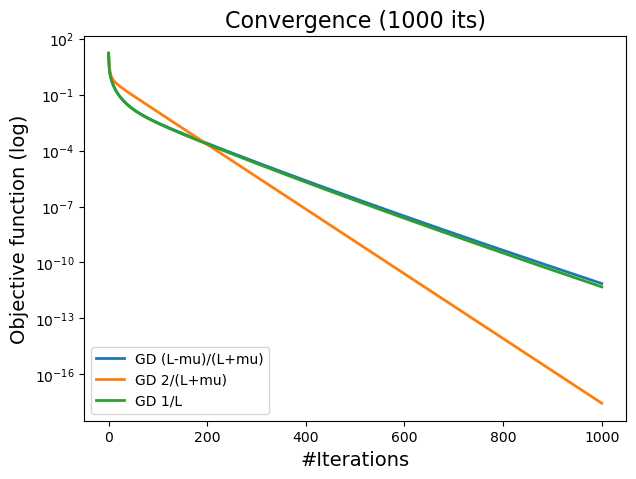

In [11]:
# Plotting the comparison
# The x-axis corresponds to the number of iterations
# The y-axis corresponds to the function value
plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    if i_val==0:
        plt.semilogy(objs[:100,i_val], label="GD (L-mu)/(L+mu)", lw=2)
    elif i_val==1:
        plt.semilogy(objs[:100,i_val], label="GD 2/(L+mu)", lw=2)
    elif i_val==2:
        plt.semilogy(objs[:100,i_val], label="GD 1/L ", lw=2)
    else:
        plt.semilogy(objs[:100,i_val], label="GD "+str(vals_stepsize[i_val]), lw=2)
plt.title("Convergence (100 its)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)

plt.figure(figsize=(7,5))
plt.set_cmap("RdPu")
for i_val in range(nvals):
    if i_val==0:
        plt.semilogy(objs[:,i_val], label="GD (L-mu)/(L+mu)", lw=2)
    elif i_val==1:
        plt.semilogy(objs[:,i_val], label="GD 2/(L+mu)", lw=2)
    elif i_val==2:
        plt.semilogy(objs[:,i_val], label="GD 1/L", lw=2)
    else:
        plt.semilogy(objs[:,i_val], label="GD "+str(vals_stepsize[i_val]), lw=2)
plt.title("Convergence ("+str(n_iter)+" its)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend(loc=3)

## <span style="color:rgb(87,104,172)">1.3 Momentum-based methods</span>

The simplest variant of gradient descent based on acceleration or momentum is the *heavy-ball* method due to Polyak. Given $\mathbf{w}_0 \in \mathbb{R}^d$ and $\mathbf{w}_{-1}=\mathbf{w}_0$, the $k$th iteration of the heavy-ball method can be written as follows:
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k) + \beta_k (\mathbf{w}_k-\mathbf{w}_{k-1}) 
    \qquad \forall k \ge 0,
$$
where $\alpha_k >0$ and $\beta_k >0$. In this notebook, we will choose these parameters to be constant.

We also consider the accelerated gradient method (also called Nesterov's method) 

$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k+\beta_k (\mathbf{w}_k-\mathbf{w}_{k-1})) + \beta_k (\mathbf{w}_k-\mathbf{w}_{k-1}) 
    \qquad \forall k \ge 0,
$$

This method is often written under the form of a double recursion. Starting from $\mathbf{z}_0=\mathbf{w}_0,t_0=0$, the method generates two vector sequences
$\{\mathbf{w}_{k},\mathbf{z}_k\}$ through the following recursion:

$$
    \left\{ 
        \begin{array}{lll}
        \mathbf{w}_{k+1} &= &\mathbf{z}_k - \alpha_k \nabla f(\mathbf{z}_k) \\
        \mathbf{z}_{k+1} &= &\mathbf{w}_{k+1} + \beta_{k+1}(\mathbf{w}_{k+1}-\mathbf{w}_k).
        \end{array}
    \right.
$$

In this recursion, the value $\alpha_k>0$ is a stepsize. For an arbitrary convex function, the $\{\beta_k\}$ sequence is computed via the following formula:
$$
    t_0 = 0,  \quad \forall k \ge 0, 
    \left\{ 
        \begin{array}{lll} 
            t_{k+1} &= &\tfrac{1}{2} (1+ \sqrt{1+4 t_{k}^2}), \\ 
            \beta_k &= &\frac{t_k-1}{t_{k+1}}
         \end{array}
     \right.
$$
while for a $\mu$-strongly convex function, the constant value $\beta_k = \tfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$ is used, where $L$ is the Lipschitz constant for the gradient.

### <span style="color:rgb(87,104,172)">Question 3 - Implementing accelerated schemes</span>

**Fill out the code template below to implement Polyak's heavy ball method as well as the two variants of Nesterov's method using a constant stepsize.**

In [12]:
# Momentum-based methods for quadratic functions
def momentum_quad(w0,C,stepsize,method="nesterov",momentum=None,n_iter=100,verbose=False): 
    """
        A generic code for Polyak's heavy-ball method and Nesterov's accelerated gradient 
        variants on quadratic functions.
        
        Inputs:
            w0: Initial vector
            C: Data matrix
            stepsize: Constant value for the stepsize
            method: Type of acceleration technique that is used
                'heavyball': Heavy-ball method
                'nesterov': Accelerated gradient for convex functions (Nesterov,default)
                'nesterovstrong': Accelerated gradient for strongly convex functions
            momentum: Constant value for the momentum parameter (only used if method!='nesterov')
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
            
        Outputs:
            z_output: Final iterate of the method
            objvals: History of function values in z (output as a Numpy array of length n_iter+1)
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    
    # Initial value of current and next iterates   
    w = w0.copy()
    w_new = w0.copy()
    z = w0.copy() # Extra sequence for momentum
    
    if method=='nesterov':
        # Initialize parameter sequence
        tk = 0
        tkp1 = 1
        momentum = 0
 
    # Initialize iteration counter
    k=0
    
    # Initial objective
    obj = 0.5*z.dot(C.dot(z)) 
    objvals.append(obj);
    
    # Plot the initial values if required
    if verbose:
        print("Accelerated Gradient/"+method)
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    #######################
    # Main loop
    while (k < n_iter):
        
        #### THIS SECTION SHOULD BE FILLED OUT
        
        
        if method=='heavyball':
            # Compute gradient
            g = C.dot(w_new)
            # Compute momentum term and update w
            z[:] = w_new - w
            w[:] = w_new[:]
            # Add momentum step
            w_new[:] = w_new -stepsize*g + momentum*z
        else:
            # Gradient step
            g = C.dot(z)
            w_new[:] = z - stepsize * g
            # Momentum step
            z[:] = w_new + momentum*(w_new-w)
            # Update sequence
            w[:] = w_new[:]
        
        
        # Adjusting the momentum parameter if needed
        if method=='nesterov':
            tkp1 = 0.5*(1+sqrt(1+4*(tk**2)))
            momentum = (tk-1)/tkp1
            tk = tkp1
        
        #### END SECTION TO BE FILLED
        
        # Compute and plot the new objective value and distance to the minimum
        if method=='heavyball':
            obj = 0.5*w.dot(C.dot(w))
        else:
            obj = 0.5*z.dot(C.dot(z))
        objvals.append(obj)
        
        # Plot these values if required
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))   
        
        # Increment the iteration counter
        k += 1
    
    # End loop
    #######################
    
    
    # Output
    z_output = z.copy()
          
    return z_output, np.array(objvals)

### <span style="color:rgb(87,104,172)">Question 4 - Comparing accelerated and non-accelerated methods</span>

**The script below compares the following four methods on the strongly convex problem:**

**a) Gradient descent with stepsize $\tfrac{1}{L}$.**

**b) Heavy-ball method with stepsize $\tfrac{4}{(\sqrt{\mu}+\sqrt{L})^2}$ and momentum parameter $\tfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$.**

**c) Nesterov's method with stepsize $\tfrac{1}{L}$ and variable momentum parameter.**

**d) Nesterov's method with stepsize $\tfrac{1}{L}$ and momentum parameter $\tfrac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$.**

**Run the scripts below and comment on the results. Do they match the theoretical guarantees of those algorithms?**

Average function value for GD: 7.158419227084983e-05
Average function value for Heavy Ball 5.186497315558575e-21
Average function value for Nesterov (convex version) 1.268841444092917e-07
Average function value for Nesterov (strongly convex version) 5.2673185575457423e-23


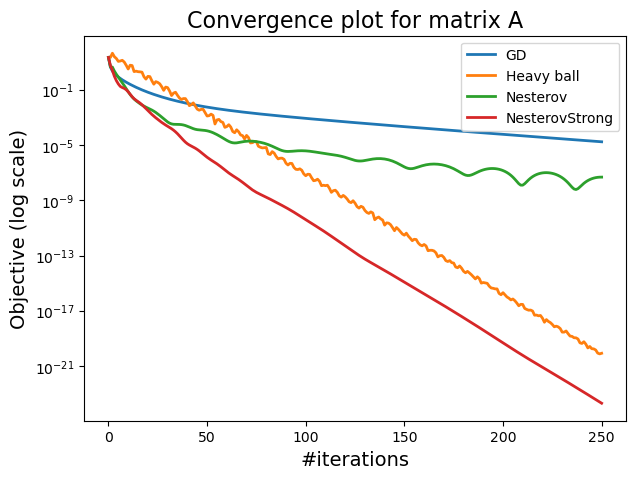

In [13]:
# Implementation - Running all methods with 10 random initial points
nruns=10
nits=250

beta = (sqrt(L)-sqrt(mu))/(sqrt(L)+sqrt(mu))
stepsize_hb = 4/((sqrt(mu)+sqrt(L))**2)

avg_gd = 0
avg_hb = 0
avg_n = 0
avg_ns = 0

for i in range(nruns):
    w0 = randn(d)
    w_gd, obj_gd = gd_quad(w0,C,1/L,nits)
    avg_gd += obj_gd[-1]
    w_hb, obj_hb = momentum_quad(w0,C,stepsize_hb,'heavyball',beta,nits)
    avg_hb += obj_hb[-1]
    w_n, obj_n = momentum_quad(w0,C,1/L,'nesterov',None,nits)
    avg_n += obj_n[-1]
    w_ns, obj_ns = momentum_quad(w0,C,1/L,'nesterovstrong',beta,nits)
    avg_ns += obj_ns[-1]
    
    
print('Average function value for GD:',avg_gd/nruns)
print('Average function value for Heavy Ball',avg_hb/nruns)
print('Average function value for Nesterov (convex version)',avg_n/nruns)
print('Average function value for Nesterov (strongly convex version)',avg_ns/nruns)

# Implementation - Compare both variants on 1 run
plt.figure(figsize=(7, 5))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_hb, label="Heavy ball", lw=2)
plt.semilogy(obj_n, label="Nesterov", lw=2)
plt.semilogy(obj_ns, label="NesterovStrong", lw=2)
plt.title("Convergence plot for matrix A", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#### <span style="color:rgb(87,104,172)">Answer to question 4</span>

Out of the two Nesterov variants, only one (that tailored for the strongly convex setting, using a constant stepsize) can achieve the optimal convergence rate for strongly convex functions. This rate is also that established for the heavy-ball method, and we do observe that both methods converge at a better rate than gradient descent, or the Nesterov method for convex problems.

Note that the picture is much clearer if we allow for a large number of iterations, but even with $100$ iterations gradient descent gets a worse convergence rate.

# <span style="color:rgb(87,104,172)">Part 2 - Convex Empirical Risk Minimization</span>

We now consider empirical risk minimization problems, that are at the center of this course. We will study the performance of gradient descent on two finite-sum problems based on learning a linear model from synthetic data. This will require a more generic implementation of gradient than that from the first part of this notebook.

## <span style="color:rgb(87,104,172)">2.1 - Generating the data</span>

We consider a dataset $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, available in the form of:

- a feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- and a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

Given this dataset, we will seek a linear model parameterized by a vector $\mathbf{w}$ that explains the data according to a certain loss function $\ell$. This results in the following formulation:
$$
    \min_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad f_i(\mathbf{w}) = \ell(\mathbf{x}_i^T\mathbf{w},y_i) + \frac{\lambda}{2}\|\mathbf{w}\|^2_2.
$$
where $\lambda \ge 0$ is an optional regularization parameter *(more on this in the lectures on regularization)*.

The dataset will be produced according to the procedure below.

In [14]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort from INRIA.

def simu_linmodel(w, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

The data is thus produced from a linear model corrupted with noise: $\mathbf{y} = \mathbf{X} \mathbf{w}^* + \mathbf{\epsilon}$, where $\mathbf{\epsilon}$ follows a Gaussian distribution. Our goal will thus be to learn a linear model from the data.

## <span style="color:rgb(87,104,172)">2.2 Linear regression</span>

In *linear regression*, we seek a linear model that explains the data based on minimizing a least-squares objective:
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) 
    := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2_2 + \frac{\lambda}{2}\|\mathbf{w}\|^2_2 
$$ 
for some $\lambda \ge 0$.

### <span style="color:rgb(87,104,172)">Observations</span> 

- The function $f$ is quadratic.
- The function $f$ is $L$-smooth with $L = \frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda$. 
- The function $f$ is convex, and $(\sigma_{\min}(X)+\lambda)$-strongly convex when $\sigma_{\min}(X)+\lambda>0$, where $\sigma_{\min}(X)$ denotes the minimum singular value of $X$.

### <span style="color:rgb(87,104,172)">Details</span> 

One can rewrite the objective function as
$$
    f(\mathbf{w}) = \frac{1}{2}\mathbf{w}^T \left(\frac{\mathbf{X}^T \mathbf{X}}{n} + \lambda \mathbf{I}_d\right)\mathbf{w} - \frac{1}{n}\mathbf{y}^T \mathbf{X} \mathbf{w} + \frac{1}{2} \mathbf{y}^T \mathbf{y}.
$$
The gradient of the objective function above is given by:
$$
    \nabla f(\mathbf{w}) = \left( \frac{\mathbf{X}^T \mathbf{X}}{n} + \lambda \mathbf{I}_d \right)\mathbf{w} - \frac{1}{n}\mathbf{X}^T \mathbf{y}
    = \frac{1}{n}\mathbf{X}^T (\mathbf{X} \mathbf{w} - \mathbf{y}) + \lambda \mathbf{w}.
$$
For any $\mathbf{w},\mathbf{v} \in \mathbb{R}^d$, the formula for the gradient gives:
$$
    \|\nabla f(\mathbf{v}) -\nabla f(\mathbf{w})\| 
    = \left\|\frac{\mathbf{X}^T \mathbf{X}}{n} \mathbf{v} + \lambda \mathbf{v} - \frac{\mathbf{X}^T \mathbf{X}}{n}\mathbf{w} - \lambda \mathbf{w} \right\| 
    \le \frac{\|\mathbf{X}^T \mathbf{X}\|}{n}\|\mathbf{v}-\mathbf{w}\| + \lambda \|\mathbf{v}-\mathbf{w}\|.
$$
The gradient $\nabla f$ is thus $\left(\frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda\right)$-Lipschitz continuous.

## <span style="color:rgb(87,104,172)">2.3 Logistic regression</span>

In *logistic regression*, we still consider a linear model, but for classification purposes (here $y_i \in \{-1,1\}$). We use a loss function better suited for classification:
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} f(\mathbf{w}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{w}), \qquad 
    f_i(\mathbf{w})=\log(1+\exp(-y_i \mathbf{x}_i^T \mathbf{w}))+\frac{\lambda}{2}\|\mathbf{w}\|^2_2,
$$
where $\lambda \ge 0$ is a regularization parameter.

### <span style="color:rgb(87,104,172)">Observations</span> 

- For any $\mathbf{w} \in \mathbb{R}^d$, one has
$$
\nabla f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n  -\frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{w}.
$$
- The function $f$ is convex and even $\lambda$-strongly convex when $\lambda>0$.
- The function $f$ is $L$-smooth with $L =\frac{\|\mathbf{X}^T \mathbf{X}\|}{4n}+\lambda$.

#### <span style="color:rgb(87,104,172)">Details</span> 

1. The derivative of $t \mapsto \log(1+\exp(-t))$ is $t \mapsto \frac{-\exp(-t)}{1+\exp(-t)} = -\frac{1}{1+\exp(t)}$. Combining this with the linear function $\mathbf{w} \mapsto y_i \mathbf{x}_i^T \mathbf{w}$, we get for every $i$ that
$$
\nabla f_i(\mathbf{w}) = - \frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{w}.
$$
and 
$$
\nabla f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n  -\frac{y_i}{1 + \exp(y_i \mathbf{x}_i^T \mathbf{w})} \mathbf{x}_i + \lambda \mathbf{w}
$$
2. One way to obtain a Lipschitz constant for the gradient is to bound the second-order derivative, which is given by:
$$
\nabla^2 f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n  
\frac{\exp(-y_i \mathbf{x}_i^T \mathbf{w})}{(1 + \exp(-y_i \mathbf{x}_i^T \mathbf{w}))^2} \mathbf{x}_i \mathbf{x}_i^T + \lambda \mathbf{I}_d,
$$
where $\mathbf{I}_d$ is the identity matrix. The result follows by noticing that $t \mapsto \tfrac{e^{t}}{(1+\exp(t))^2}$  is always less than or equal to $\tfrac{1}{4}$ (its value at the origin), we obtain that
$$
\| \nabla^2 f(\mathbf{w}) \| \le L:=\frac{\|\mathbf{X}^T \mathbf{X}\|}{4n}+\lambda,
$$
hence $\nabla f$ is $L$-Lipschitz continuous.

## <span style="color:rgb(87,104,172)">2.4 Python class for regression problems</span>

In [15]:
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            X: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, X, y,lbda=0,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda
        
    # Objective value
    def fun(self, w):
        if self.loss=='l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) + self.lbda * norm(w) ** 2 / 2.

    
    # Full gradient computation
    def grad(self, w):
        if self.loss=='l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n + self.lbda * w

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.X)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

The first script below generates two problem instances (one for each class), the second checks the implementation of the derivatives, and the third one computes an approximate solution for each problem.

In [16]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose

d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

Xlin, ylin = simu_linmodel(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_linmodel(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Taking the logarithm for binary classification

pblinreg = RegPb(Xlin, ylin,lbda,loss='l2')
pblogreg = RegPb(Xlog, ylog,lbda,loss='logit')

## <span style="color:rgb(87,104,172)">2.5 Numerical estimates of $\min$ and $\mathrm{argmin}$</span>

In this lab, we work with relatively simple loss functions (and a moderate number of data points): we can thus efficiently compute a solution using a second-order method. This provides us with a target objective value as well as a target vector of weights.

In [17]:
# Use L-BFGS-B to determine a solution for both problems

w_init = np.zeros(d)
# Compute the optimal solution for linear regression
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Linear regression:")
print("\t Numerical minimal value:",f_min_lin)
print("\t Numerical minimum gradient norm:",norm(pblinreg.grad(w_min_lin)))

# Compute the optimal solution for logistic regression
w_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Logistic regression:")
print("\t Numerical minimal value:",f_min_log)
print("\t Numerical minimum gradient norm:",norm(pblogreg.grad(w_min_log)))

Linear regression:
	 Numerical minimal value: 0.5562291656828048
	 Numerical minimum gradient norm: 2.880310561679997e-10
Logistic regression:
	 Numerical minimal value: 0.5588577967545119
	 Numerical minimum gradient norm: 3.7546243855319086e-09


These solutions will enable us to study the behavior of the distance to optimality in terms of function values 
$f(\mathbf{w}_k)-f^*$ and iterates $\|\mathbf{w}_k -\mathbf{w}^*\|$. 

*Note: Recall that $\|\nabla f(\mathbf{w}_k)\|^2 \ge 2 \mu (f(\mathbf{w}_k)-f^*)$ for a $\mu$-strongly convex, continuously differentiable function with optimal value $f^*$, thus the gradient could also be used as an upper estimate of the distance to optimality in terms of function values.*

## <span style="color:rgb(87,104,172)">2.6 Gradient descent implementation</span>

We will investigate several techniques for selecting the stepsize in a predetermined or adaptive fashion in gradient descent. Those are by no means exhaustive, but give a nice overview of existing options (see upcoming lectures for more details about the theory behind those methods). We will consider the three following options:

- *Constant stepsize:* $\alpha_k = \frac{\bar{\alpha}}{L}$, where $L$ is the Lipschitz constant for $\nabla f$ (assumed to be known in that case).

- *Decreasing stepsize:* $\alpha_k = \frac{\bar{\alpha}}{(k+1)^a}$, where $a>0$ is given as input

- *Armijo-type line search:* $\alpha_k=\frac{\bar{\alpha}}{2^{j_k}}$, where $j_k$ is the smallest nonnegative integer such that
$$
f\left(\mathbf{w}_k-\frac{\bar{\alpha}}{2^{j_k}}\nabla f(\mathbf{w}_k)\right) < f(\mathbf{w}_k) - 0.0001 \frac{\alpha}{2^{j_k}}\|\nabla f(\mathbf{w}_k)\|^2.
$$
In practice, the line search should stop if the decrease condition is satisfied or $\frac{\bar{\alpha}}{2^{j_k}} < 10^{-10}$. Note that the parameters $2$,$0.0001$ and $10^{-10}$ are set for simplicity.


### <span style="color:rgb(87,104,172)">Question 5</span>

**Fill out the function template below with the gradient descent iteration and the three rules for the stepsize above (that are encoded using input parameters).**

In [18]:
# Gradient descent
def gd_reg(w0,problem,wopt,stepchoice=0,stepbar=1, n_iter=1000, verbose=False): 
    """
        An implementation of gradient descent with several stepsize rules.
        
        Inputs:
            w0: Initial point
            problem: Problem structure
                problem.fun(w) Objective value
                problem.grad(w) Gradient
                problem.lipgrad() Lipschitz constant for the gradient
            wopt: Target point for the optimization (approximate optimum computed beforehand)
            stepchoice: Rule for choosing the stepsize (see above)
                0: Constant equal to 1/L where L is a Lipschitz constant for the gradient
                a>0: Decreasing, set to 1/((k+1)**a)
                -1: Armijo line search
            stepbar: Initial step size (used when stepchoice = 1)
            n_iter: Maximum iteration number
            verbose: Boolean value indicating whether iteration-level information should be displayed.
      
        Outputs:
            w_output: Last iterate of the method
            objvals: History of function values (Numpy array of length n_iter)
            distits: History of distances to the target point (Numpy array of length n_iter)
            ngvals: History of gradient norms (Numpy array of length n_iter)
            
    """
    
    ############
    # Initialization

    # History of function values
    objvals = []
    
    # History of gradient norms
    ngvals = []
    
    # History of distances to the target
    distits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of the incumbent, a.k.a. current iterate
    w = w0.copy()

    # Initialize the iteration count
    k=0    
    
    # Initial function value
    obj = problem.fun(w) 
    objvals.append(obj);
    
    # Initial gradient
    g = problem.grad(w)
    ng = norm(g)
    ngvals.append(ng)
    
    # Distance between the current point and the optimal point
    dist = norm(w-wopt)
    distits.append(dist)

    # Plot initial values 
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","stepsize"]]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        #####################################################################################
        ###### THIS PART SHOULD BE FILLED WITH THE ACTUAL STEPSIZE CALCULATION AND ITERATION
        
        # 1 - Define the stepsize s based on stepchoice, k (iteration index), 
        # L (Lipschitz constant), step0 (initial value) and g (the gradient)
        if stepchoice==0:
            # Constant stepsize
            s = (1/L)
        elif stepchoice>0:
            # Decreasing stepsize
            s = stepbar/((k+1)**stepchoice)
        elif stepchoice==-1:
            # Line search (inner while loop)
            s = stepbar
            while (problem.fun(w-s*g) >= obj - 0.0001*s*(ng**2)) and (s>1e-10):
                s = 0.5*s
        
        # 2 - Perform the gradient descent iteration using the stepsize s and the gradient g
        w[:] = w - s*g
      
            
        ###### NOTHING MORE TO FILL PAST THIS POINT. 
        ###### MAKE SURE THAT w NOW CONTAINS THE NEXT ITERATE AND s THE ASSOCIATED STEPSIZE
        ####################################################################################
        
        
        # Plot relevant information
        if verbose:        
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8),("%.2e" % s).rjust(8)]))
        
        # Compute values associated with the next iterate
        obj = problem.fun(w)
        objvals.append(obj)
        g = problem.grad(w)
        ng = norm(g)
        ngvals.append(ng)
        dist = norm(w-wopt)
        distits.append(dist)
        
        # Increase iteration counter
        k += 1
    
    # End main loop
    ######################
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(distits), np.array(ngvals)

### <span style="color:rgb(87,104,172)">Question 6</span>

**a) Run gradient descent when using the four following rules on linear regression:**

- $\alpha_k = \frac{1}{L}$;

- $\alpha_k = \frac{1}{k+1}$;

- $\alpha_k = \frac{1}{\sqrt{k+1}}$;

- $\alpha_k$ **chosen through Armijo line search with $\bar{\alpha}=1$.**

**Compare the convergence curves in terms of function values $\{f(\mathbf{w}_k)\}$ and $\{f(\mathbf{w}_k)-f^*_{lin}\}$, where 
$f^*_{lin}$ is the value computed in Section 2.5.**

**b) Plot the gradient norms and the distances to optimum as a function of the number of iterations. Are those plots consistent with the others? Do they bring additional insights about the methods?**

**c) What other curves and/or quantities could you plot for comparing those four variants, so that the comparison is the fairest possible?** 

In [19]:
# Answer to Question 6a)

# Run four variants of gradient descent using the same initial point
w0 = np.zeros(d)
_, obj_a, dist_a, ngrad_a = gd_reg(w0,pblinreg,w_min_lin,stepchoice=0,stepbar=1, n_iter=50)
_, obj_b, dist_b, ngrad_b = gd_reg(w0,pblinreg,w_min_lin,stepchoice=1,stepbar=1, n_iter=50)
_, obj_c, dist_c, ngrad_c = gd_reg(w0,pblinreg,w_min_lin,stepchoice=0.5,stepbar=1, n_iter=50)
_, obj_d, dist_d, ngrad_d = gd_reg(w0,pblinreg,w_min_lin,stepchoice=-1,stepbar=1, n_iter=50)

# Best/Final objective value
print("Final objective value for GD - 1/L",obj_a[-1])
print("Final objective value for GD - 1/(k+1)",obj_b[-1])
print("Final objective value for GD - 1/(sqrt(k+1))",obj_c[-1])
print("Final objective value for GD - Line Search",obj_d[-1])


Final objective value for GD - 1/L 0.5562291656828048
Final objective value for GD - 1/(k+1) 0.5569217661887065
Final objective value for GD - 1/(sqrt(k+1)) 0.5562291691977336
Final objective value for GD - Line Search 0.5562291656828047


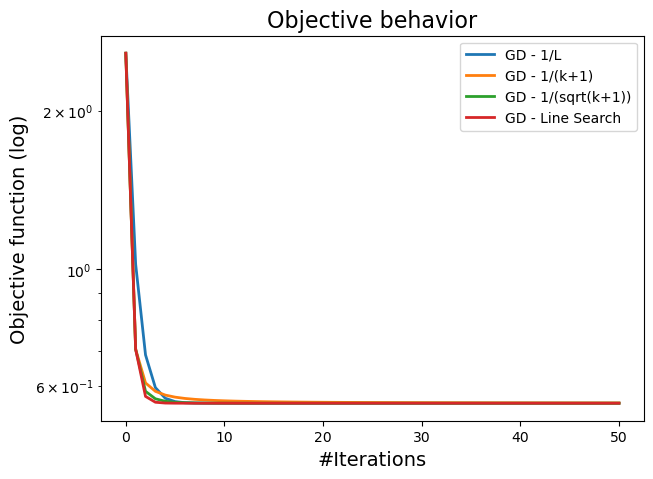

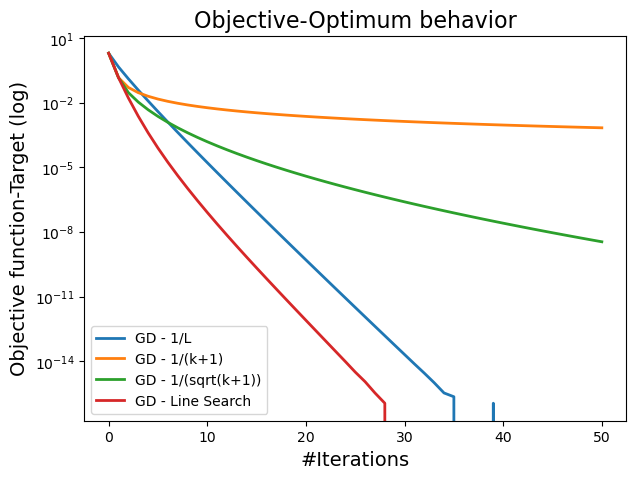

In [20]:
# Answer to question 6b)

# We begin by plotting the change in the function value (in log scale) as a function of the iteration number
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a, label="GD - 1/L", lw=2)
plt.semilogy(obj_b, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(obj_d, label="GD - Line Search", lw=2)
plt.title("Objective behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function (log)", fontsize=14)
plt.legend()

# We can also plot the change in function value relatively to the target value 
# Note: In log scale, the values f(w)-vmin close to 0 do not appear


#### Plot the behavior of all four methods in terms of relative objective value
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(obj_d-f_min_lin, label="GD - Line Search", lw=2)
plt.title("Objective-Optimum behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function-Target (log)", fontsize=14)
plt.legend()

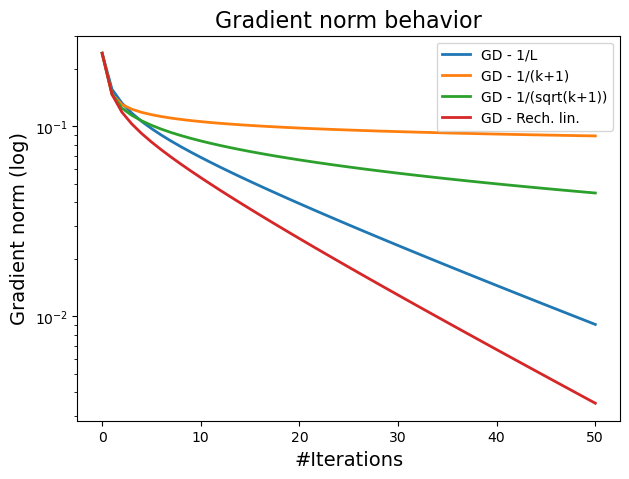

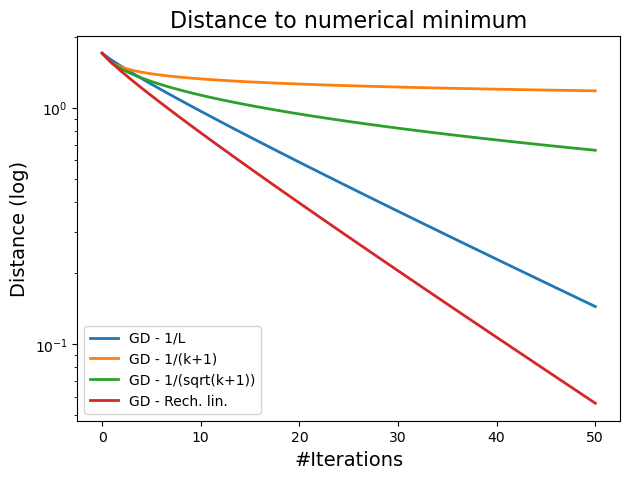

In [22]:
# Answer to question 6c)

#### Plot the behavior of all four methods in terms of gradient norm
plt.figure(figsize=(7, 5))
plt.semilogy(ngrad_a, label="GD - 1/L", lw=2)
plt.semilogy(ngrad_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(ngrad_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(ngrad_d, label="GD - Rech. lin.", lw=2)
plt.title("Gradient norm behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Gradient norm (log)", fontsize=14)
plt.legend()

#### Plot the behavior of all four methods in terms of distance to numerical optimum
plt.figure(figsize=(7, 5))
plt.semilogy(dist_a, label="GD - 1/L", lw=2)
plt.semilogy(dist_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(dist_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(dist_d, label="GD - Rech. lin.", lw=2)
plt.title("Distance to numerical minimum", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Distance (log)", fontsize=14)
plt.legend()

#### <span style="color:rgb(87,104,172)">Interpretation of the results in question 6</span>

a) The comparison is made easier with the use of the numerical optimal value.

a)The sequence $\left\{\tfrac{1}{k+1}\right\}_k$ is a decreasing sequence, hence the method takes smaller and smaller steps as the iteration count increases. Even though these steps lead to a decrease in function value, this decrease is small because the steps that are taken are small in norm (small gradient norm+small stepsize). This explains why the method appears to converge, but rather slowly. This trend is less visible for the $\tfrac{1}{\sqrt{k+1}}$ variant, because thestepsize sequence $\left\{\tfrac{1}{\sqrt{k+1}}\right\}_k$ converges to $0$ at a slower rate than $\left\{\tfrac{1}{k+1}\right\}_k$.

b) The iteration output of the method shows both the function value and the gradient norm not moving starting from iteration 25. This behavior is called stalling: the stepsizes that are computed through line search are below our threshold, and therefore the method no longer makes meaningful changes in the parameters.

b) If we restrict ourselves to 5 iterations, the decreasing stepsize variants decrease the gradient norm and the function value more quickly. For the very first iterations, this behavior can be partially explained by the fact that those methods take longer steps than the fixed stepsize variant (e.g. 1 vs 0.6 for the first iteration). Those steps lead to a better point, which in turns puts them in good position for the next iteration. Eventually, however, the decreasing stepsizes go significantly below the $1/L$ threshold, and the constant stepsize choice leads to more improvement on the long run.

c) The above plots do not account for the fact that an iteration of line search may require multiple function evaluations. A better plot in this regard would have the number of function evaluations on the x-axis.

### <span style="color:rgb(87,104,172)">Question 7</span>

**Repeat the experiments of Question 6 using logistic regression. Try to find the best possible rule for the stepsize.**

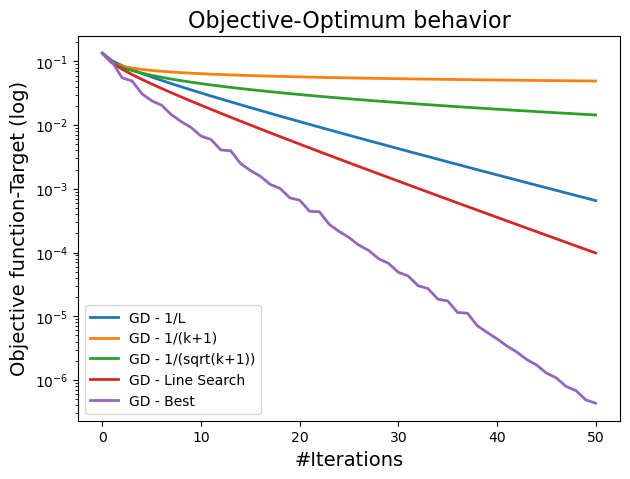

In [23]:
# Answer to question 7)

# Plotting the behavior of all methods
# Run four variants of gradient descent using the same initial point
w0 = np.zeros(d)
_, obj_a, dist_a, ngrad_a = gd_reg(w0,pblogreg,w_min_log,stepchoice=0,stepbar=1, n_iter=50)
_, obj_b, dist_b, ngrad_b = gd_reg(w0,pblogreg,w_min_log,stepchoice=1,stepbar=1, n_iter=50)
_, obj_c, dist_c, ngrad_c = gd_reg(w0,pblogreg,w_min_log,stepchoice=0.5,stepbar=1, n_iter=50)
_, obj_d, dist_d, ngrad_d = gd_reg(w0,pblogreg,w_min_log,stepchoice=-1,stepbar=1, n_iter=50)
_, obj_e, dist_e, ngrad_e = gd_reg(w0,pblogreg,w_min_log,stepchoice=-1,stepbar=10, n_iter=50)


#### Plot the behavior of all four methods in terms of relative objective value
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_log, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c-f_min_log, label="GD - 1/(sqrt(k+1))", lw=2)
plt.semilogy(obj_d-f_min_log, label="GD - Line Search", lw=2)
plt.semilogy(obj_e-f_min_log, label="GD - Best", lw=2)
plt.title("Objective-Optimum behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function-Target (log)", fontsize=14)
plt.legend()

# <span style="color:rgb(87,104,172)">Bonus part: Silver stepsizes for gradient descent</span>

In this section, we investigate recent stepsize choices proposed in the literature that lead to improved convergence 
rates for gradient descent.

In [24]:
# Gradient descent
def gd_reg_modern(w0,problem,wopt,stepchoice=0,stepbar=1, n_iter=1000, verbose=False): 
    """
        An implementation of gradient descent with several stepsize rules.
        
        Inputs:
            w0: Initial point
            problem: Problem structure
                problem.fun(w) Objective value
                problem.grad(w) Gradient
                problem.lipgrad() Lipschitz constant for the gradient
            wopt: Target point for the optimization (approximate optimum computed beforehand)
            stepchoice: Rule for choosing the stepsize (see above)
                0: Constant equal to 1/L where L is a Lipschitz constant for the gradient
                a>0: Decreasing, set to 1/((k+1)**a)
                -1: Armijo line search
                -2: Grimmer stepsizes (1.5 and 2.9)
                -3: Silver stepsizes
            stepbar: Initial step size (used when stepchoice = 1)
            n_iter: Maximum iteration number
            verbose: Boolean value indicating whether iteration-level information should be displayed.
      
        Outputs:
            w_output: Last iterate of the method
            objvals: History of function values (Numpy array of length n_iter)
            distits: History of distances to the target point (Numpy array of length n_iter)
            ngvals: History of gradient norms (Numpy array of length n_iter)
            
    """
    
    ############
    # Initialization

    # History of function values
    objvals = []
    
    # History of gradient norms
    ngvals = []
    
    # History of distances to the target
    distits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of the incumbent, a.k.a. current iterate
    w = w0.copy()

    # Initialize the iteration count
    k=0    
    
    # Initial function value
    obj = problem.fun(w) 
    objvals.append(obj);
    
    # Initial gradient
    g = problem.grad(w)
    ng = norm(g)
    ngvals.append(ng)
    
    # Distance between the current point and the optimal point
    dist = norm(w-wopt)
    distits.append(dist)
    
    # Silver stepsizes
    rho = 1+sqrt(2)
    silver = [1+rho**((j & -j).bit_length()-2) for j in range(1,n_iter+1)]

    # Plot initial values 
    if verbose:
        print("Gradient descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","stepsize"]]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        #####################################################################################
        
        # 1 - Define the stepsize s based on stepchoice, k (iteration index), 
        # L (Lipschitz constant), step0 (initial value) and g (the gradient)
        if stepchoice==0:
            # Constant stepsize
            s = (1/L)
        elif stepchoice>0:
            # Decreasing stepsize
            s = stepbar/((k+1)**stepchoice)
        elif stepchoice==-1:
            # Line search (inner while loop)
            s = stepbar
            while (problem.fun(w-s*g) >= obj - 0.0001*s*(ng**2)) and (s>1e-10):
                s = 0.5*s
        elif stepchoice==-2:
            if (k % 2==0):
                s = 2.9/L
            else:
                s = 1.5/L
        elif stepchoice==-3:
            s = silver[k]/L
        
        # 2 - Perform the gradient descent iteration using the stepsize s and the gradient g
        w[:] = w - s*g
      
        ####################################################################################
        
        
        # Plot relevant information
        if verbose:        
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % dist).rjust(8),("%.2e" % s).rjust(8)]))
        
        # Compute values associated with the next iterate
        obj = problem.fun(w)
        objvals.append(obj)
        g = problem.grad(w)
        ng = norm(g)
        ngvals.append(ng)
        dist = norm(w-wopt)
        distits.append(dist)
        
        # Increase iteration counter
        k += 1
    
    # End main loop
    ######################
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(distits), np.array(ngvals)

In [26]:
# Bonus experiment : Define a convex loss function
pblogreg_0 = RegPb(Xlog, ylog,0,loss='logit')

# Compute the optimal solution for logistic regression
w_min_log_0, f_min_log_0, _ = fmin_l_bfgs_b(pblogreg_0.fun, w_init, pblogreg_0.grad, args=(), pgtol=1e-30, factr =1e-30)
print("Logistic regression:")
print("\t Numerical minimal value:",f_min_log_0)
print("\t Numerical minimum gradient norm:",norm(pblogreg_0.grad(w_min_log_0)))

Logistic regression:
	 Numerical minimal value: 0.4571597030919861
	 Numerical minimum gradient norm: 2.0093917594848487e-09


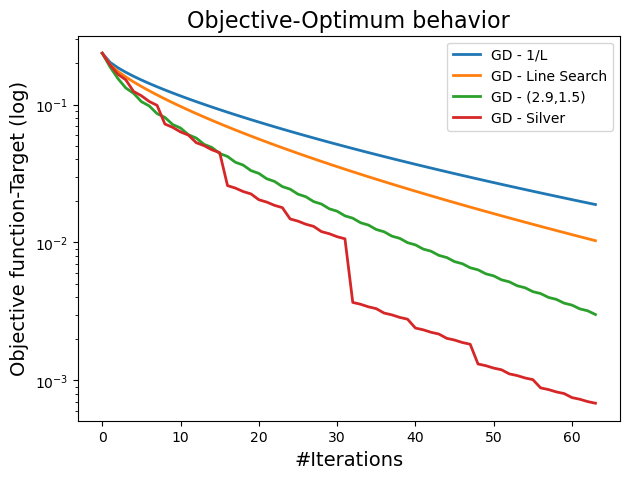

In [27]:
# Plotting the behavior of all methods
# Run four variants of gradient descent using the same initial point
w0 = np.zeros(d)
_, obj_a, dist_a, ngrad_a = gd_reg_modern(w0,pblogreg_0,w_min_log_0,stepchoice=0,stepbar=1, n_iter=63)
_, obj_b, dist_b, ngrad_b = gd_reg_modern(w0,pblogreg_0,w_min_log_0,stepchoice=-1,stepbar=1, n_iter=63)
_, obj_c, dist_c, ngrad_c = gd_reg_modern(w0,pblogreg_0,w_min_log_0,stepchoice=-2,stepbar=1, n_iter=63)
_, obj_d, dist_d, ngrad_d = gd_reg_modern(w0,pblogreg_0,w_min_log_0,stepchoice=-3,stepbar=1, n_iter=63)


#### Plot the behavior of all four methods in terms of relative objective value
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log_0, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_log_0, label="GD - Line Search", lw=2)
plt.semilogy(obj_c-f_min_log_0, label="GD - (2.9,1.5)", lw=2)
plt.semilogy(obj_d-f_min_log_0, label="GD - Silver", lw=2)
plt.title("Objective-Optimum behavior", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective function-Target (log)", fontsize=14)
plt.legend()

In [ ]:
# References for the bonus part

# J. M. Altschuler and P. A. Parrilo, Acceleration by stepsize hedging: Silver Stepsize Schedule for smooth 
# convex optimization, Math. Programming, 2024.
# B. Grimmer, Provably faster gradient descent via long steps, SIAM J. Optim, 34(3):2588-2608, 2024

In [26]:
# Version 1.2 - C. W. Royer, October 2025